In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


In [4]:
# read data
train = pd.read_csv('./data/train.txt', delimiter=';', header=None, names=['data', 'label'])
test = pd.read_csv('./data/test.txt', delimiter=';', header=None, names=['data', 'label'])
val = pd.read_csv('./data/val.txt', delimiter=';', header=None, names=['data', 'label'])
comb_data = pd.concat([train, val, test])
comb_data.shape

(20000, 2)

In [5]:
le = LabelEncoder()
comb_data['label_enc'] = le.fit_transform(comb_data['label'])
comb_data.head()

,data,label,label_enc
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,4
2,im grabbing a minute to post i feel greedy wrong,anger,0
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,0


In [6]:
def tokenize_data(df):
    sents = df['data']
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokens = []
    for i in sents:
        tokens.append(tokenizer.tokenize(i.lower()))
    return tokens
tokenized = tokenize_data(comb_data)

In [7]:
def remove_stopwords(tokenized):
    sw = set(stopwords.words('english'))
    sw_removed = []
    for sent in tokenized:
        filtered = []
        for word in sent:
            if word not in sw:
                filtered.append(word)
        sw_removed.append(filtered)
    return sw_removed
stopwords_removed = remove_stopwords(tokenized)

In [8]:
def lemmatize(processed):
    lemma = WordNetLemmatizer()
    lemmatized = []
    for sent in processed:
        filtered = []
        for word in sent:
            filtered.append(lemma.lemmatize(word, pos='v'))
        lemmatized.append(filtered)
    return lemmatized
lemmatized = lemmatize(stopwords_removed)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tg584\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
final_data = []
# each l is a list of processed words
for l in lemmatized:
    final_data.append(' '.join(l))
d = {'data': final_data, 'label': comb_data['label_enc'], 'label_raw': comb_data['label']}
final_df = pd.DataFrame(data=d)

In [10]:
final_df.head()

,data,label,label_raw
0,didnt feel humiliate,4,sadness
1,go feel hopeless damn hopeful around someone c...,4,sadness
2,im grab minute post feel greedy wrong,0,anger
3,ever feel nostalgic fireplace know still property,3,love
4,feel grouchy,0,anger


In [13]:
from sklearn.model_selection import train_test_split
def prepare_dataset(df, test_size=0.2, seq_len=30, embedding_dim=100):
    xtrain, xtest, ytrain, ytest = train_test_split(df['data'], df['label'], test_size=test_size, random_state=42)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df['data'])
    word_inds = tokenizer.word_index
    vocab_size = len(word_inds) + 1

    ytrain = tf.keras.utils.to_categorical(ytrain, dtype='uint8')
    ytest = tf.keras.utils.to_categorical(ytest, dtype='uint8')

    xtrain = pad_sequences(tokenizer.texts_to_sequences(xtrain), maxlen=seq_len)
    xtest = pad_sequences(tokenizer.texts_to_sequences(xtest), maxlen=seq_len)
    print('x: ', xtrain.shape)
    print(xtest.shape)
    print('y: ', ytrain.shape)
    print(ytest.shape)
    print(vocab_size)
    return xtrain, xtest, ytrain, ytest, vocab_size

xtrain, xtest, ytrain, ytest, vocab_size = prepare_dataset(final_df)

x:  (16000, 30)
(4000, 30)
y:  (16000, 6)
(4000, 6)
13660


## CNN classifier

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, Dense, GlobalMaxPooling1D, MaxPooling1D, Dropout, Embedding, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.python.ops.gen_batch_ops import batch

In [15]:
class CNN:
    def __init__(self, vocab_size, batch_size=256, epochs=20, embedding_dim=100, seq_len=30):
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.seq_len = seq_len
        self.early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0)
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=0.000001, verbose=0)
        self.model = self.build_model(vocab_size)

    def build_model(self, vocab_size):
        inputs = Input(shape=(self.seq_len,), dtype=np.int32)
        embedding = Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, input_length=self.seq_len, trainable=True)
        model = embedding(inputs)
        model = Dropout(0.2)(model)

        # conv block 1
        model = Conv1D(128, 3, activation='relu')(model)
        model = Conv1D(128, 3, activation='relu')(model)
        model = MaxPooling1D()(model)

        # conv block 2
        model = Conv1D(64, 3, activation='relu')(model)
        model = Conv1D(64, 3, activation='relu')(model)
        model = Dropout(0.2)(model)

        # conv block 3
        model = Conv1D(64, 3, activation='relu')(model)
        model = Conv1D(32, 3, activation='relu')(model)
        model = GlobalMaxPooling1D()(model)

        # FC
        model = BatchNormalization()(model)
        model = Dense(512, activation='relu')(model)
        model = Dense(128, activation='relu')(model)
        model = Dropout(0.2)(model)

        # output
        outputs = Dense(6, activation='softmax')(model)
        return tf.keras.Model(inputs, outputs, name='cnn')

    def summary(self):
        return self.model.summary()

    def train(self, xtrain, xtest, ytrain, ytest):
        opt = Adam(learning_rate=0.01)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
        history = self.model.fit(xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs, validation_data=(xtest, ytest), callbacks=[self.early_stop, self.reduce_lr], verbose=1)
        return history

In [16]:
cnn = CNN(vocab_size)
history = cnn.train(xtrain, xtest, ytrain, ytest)

Epoch 1/20
63/63 [==============================] - 7s 29ms/step - loss: 1.5926 - accuracy: 0.3299 - auc: 0.7123 - val_loss: 1.5565 - val_accuracy: 0.3338 - val_auc: 0.7549
Epoch 2/20
63/63 [==============================] - 1s 14ms/step - loss: 1.1829 - accuracy: 0.4327 - auc: 0.8519 - val_loss: 2.0520 - val_accuracy: 0.3517 - val_auc: 0.7538
Epoch 3/20
63/63 [==============================] - 1s 15ms/step - loss: 0.9229 - accuracy: 0.5770 - auc: 0.9078 - val_loss: 1.8320 - val_accuracy: 0.5755 - val_auc: 0.8439
Epoch 4/20
63/63 [==============================] - 1s 15ms/step - loss: 0.5958 - accuracy: 0.8046 - auc: 0.9632 - val_loss: 0.7369 - val_accuracy: 0.7505 - val_auc: 0.9521
Epoch 5/20
63/63 [==============================] - 1s 14ms/step - loss: 0.4775 - accuracy: 0.8516 - auc: 0.9753 - val_loss: 1.2363 - val_accuracy: 0.6270 - val_auc: 0.8936
Epoch 6/20
63/63 [==============================] - 1s 14ms/step - loss: 0.4038 - accuracy: 0.8740 - auc: 0.9815 - val_loss: 0.6892 - v

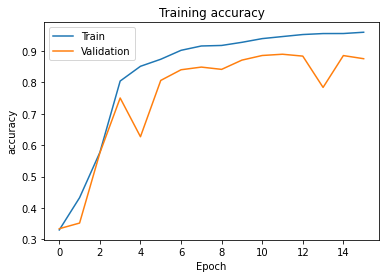

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
def plot_outs(history, name):
    plt.plot(history.history[name])
    plt.plot(history.history['val_'+name])
    plt.title('Training '+name)
    plt.ylabel(name)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.clf()

plot_outs(history, 'accuracy')


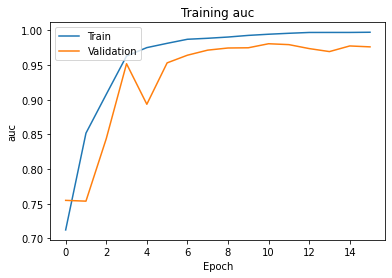

<Figure size 432x288 with 0 Axes>

In [18]:
plot_outs(history, 'auc')

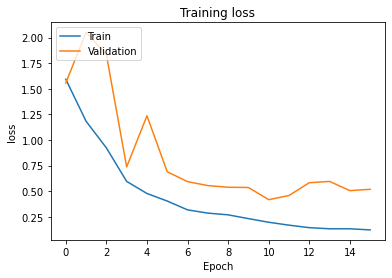

<Figure size 432x288 with 0 Axes>

In [19]:
plot_outs(history, 'loss')

In [122]:
from tensorflow.keras.layers import LSTM, Bidirectional
class RNN:
    def __init__(self, vocab_size, batch_size=256, epochs=20, embedding_dim=100, seq_len=30):
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.seq_len = seq_len
        self.early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0)
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=0.000001, verbose=0)
        self.model = self.build_model(vocab_size)

    def build_model(self, vocab_size):
        inputs = Input(shape=(self.seq_len,), dtype=np.int32)
        embedding = Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, input_length=self.seq_len, trainable=True)
        model = embedding(inputs)
        model = Dropout(0.2)(model)

        model = Bidirectional(LSTM(4, input_shape=(self.seq_len, 1), return_sequences=True))(model)
        model = Dropout(0.2)(model)
        model = Bidirectional(LSTM(4, return_sequences=True))(model)
        model = Dropout(0.2)(model)
        model = Bidirectional(LSTM(4, return_sequences=True))(model)
        model = Dropout(0.2)(model)
        model = Bidirectional(LSTM(4))(model)
        outputs = Dense(6, activation='softmax')(model)
        return tf.keras.Model(inputs, outputs)

    def summary(self):
        return self.model.summary()

    def train(self, xtrain, xtest, ytrain, ytest):
        opt = Adam(learning_rate=0.01)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
        history = self.model.fit(xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs, validation_data=(xtest, ytest), callbacks=[self.early_stop, self.reduce_lr])
        return history


In [124]:
lstm = RNN(vocab_size)
history_lstm = lstm.train(xtrain, xtest, ytrain, ytest)

Epoch 1/20
63/63 [==============================] - 23s 74ms/step - loss: 1.4784 - accuracy: 0.4581 - auc: 0.7586 - val_loss: 1.3411 - val_accuracy: 0.5270 - val_auc: 0.8067
Epoch 2/20
63/63 [==============================] - 3s 42ms/step - loss: 1.1328 - accuracy: 0.5990 - auc: 0.8685 - val_loss: 1.0526 - val_accuracy: 0.6357 - val_auc: 0.8873
Epoch 3/20
63/63 [==============================] - 3s 42ms/step - loss: 0.9027 - accuracy: 0.6741 - auc: 0.9176 - val_loss: 0.9214 - val_accuracy: 0.6417 - val_auc: 0.9155
Epoch 4/20
63/63 [==============================] - 3s 43ms/step - loss: 0.7355 - accuracy: 0.7218 - auc: 0.9444 - val_loss: 0.8230 - val_accuracy: 0.7085 - val_auc: 0.9322
Epoch 5/20
63/63 [==============================] - 3s 43ms/step - loss: 0.5893 - accuracy: 0.7949 - auc: 0.9648 - val_loss: 0.6740 - val_accuracy: 0.8012 - val_auc: 0.9514
Epoch 6/20
63/63 [==============================] - 3s 42ms/step - loss: 0.3953 - accuracy: 0.8765 - auc: 0.9821 - val_loss: 0.5091 - 

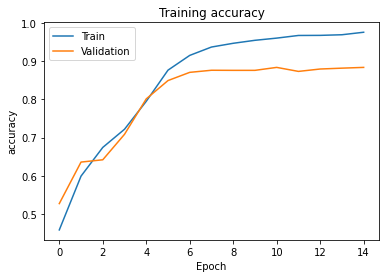

<Figure size 432x288 with 0 Axes>

In [125]:
plot_outs(history_lstm, 'accuracy')

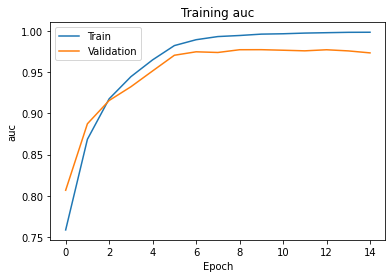

<Figure size 432x288 with 0 Axes>

In [126]:
plot_outs(history_lstm, 'auc')

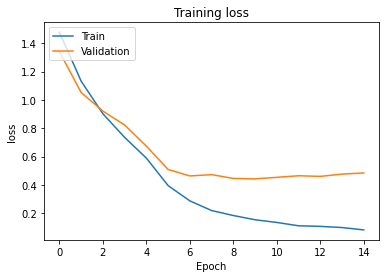

<Figure size 432x288 with 0 Axes>

In [127]:
plot_outs(history_lstm, 'loss')

# Results
LSTM performs better, but CNN runs faster